## Import data

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB


# Load data
B = pd.read_csv('data/B (power transfer factor of each bus to each line).csv', sep=';').values
P_max = pd.read_csv('data\Maximum production of generating units.csv').values.flatten()
P_min = pd.read_csv('data\Minimum production of generating units.csv').values.flatten()
min_downtime = pd.read_csv('data\Minimum down time of generating units.csv').values.flatten()
min_uptime = pd.read_csv('data\Minimum up time of generating units.csv').values.flatten()
C_g = pd.read_csv('data\Production cost of generating units.csv').values.flatten()
C_gs = pd.read_csv('data\Start-up cost of generating units.csv').values.flatten()
ramp = pd.read_csv('data\Ramping rate of generating units.csv').values.flatten()
F = pd.read_csv('data\Transmission capacity of lines.csv').values.flatten()

# Load wind data
W_cap = pd.read_csv('data/Capacity of wind farms.csv')
W1 = pd.read_csv('data\W1.csv', skiprows=3) 
W2 = pd.read_csv('data\W2.csv', skiprows=3)

# Scale wind data
W1 = np.array(W1.iloc[:,2]) * W_cap.values[0]
W2 = np.array(W2.iloc[:,2]) * W_cap.values[1]
W = np.vstack((W1, W2)).T

# Remove first row to fit with demand data
Wind = W[1:].T

# Load demand data
D = pd.read_csv('data\ConsumptionPerGridarea.csv', sep=';', decimal=',')
D = D.loc[D['GridCompany'].isin([131, 344, 16])]
D["HourDK"] = pd.to_datetime(D["HourDK"])
D = D.loc[D["HourDK"].dt.year == 2021]
D = D.pivot_table(index = "HourDK", columns = "GridCompany", values = "FlexSettledConsumption")

# Read and scale demand data
D_cap = pd.read_csv('data\Loads.csv')
D = (D/np.max(D, axis=0)) * D_cap.values.T
Demand = D.values.T




## Task 1: Understanding Unit Commitment and optimization model
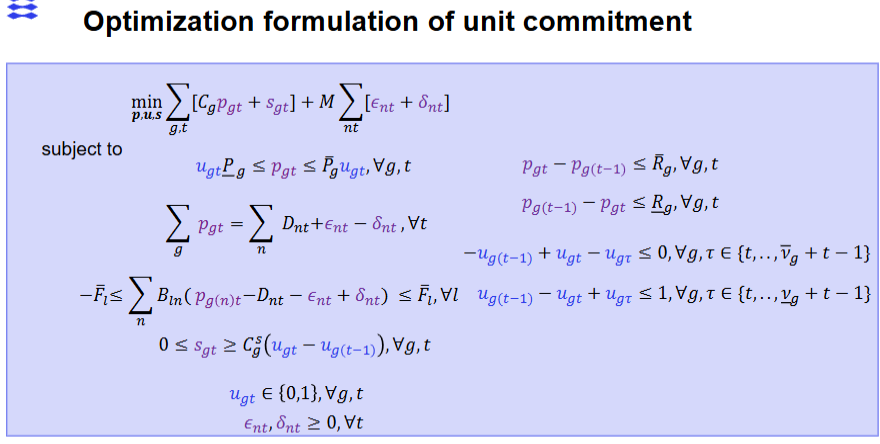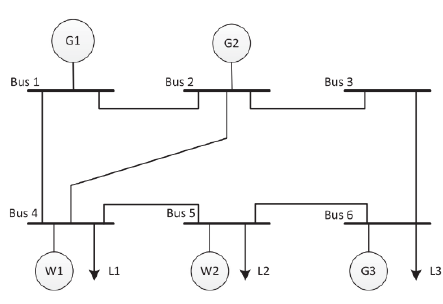

In [133]:
G = len(P_max) # number of generators
L = len(F) # number of lines
N = B.shape[1] # number of nodes
G_n = [[0],[1],[],[],[],[2]]
W_n = [[ ],[],[],[0],[1],[]]
D_n = [[],[],[],[0],[1],[2]]
M = 1000 # Big M

def unit_commitment(Wind, Demand, fixed_binary = None):
    #### Create model ####
    model = gp.Model()

    ### Parameters ###
    D, T = Demand.shape # number of time periods
    W = Wind.shape[0] # number of wind farms
    
    #### Decision variables ####
    # Production/bid in DA market
    p_g = model.addVars(G,T, lb = 0, vtype=GRB.CONTINUOUS, name="p_gt") # Power production in each generator in each time period
    p_w = model.addVars(W,T, vtype=GRB.CONTINUOUS, name="p_wt") # Power production in each wind farm in each time period
    u = model.addVars(G,T, vtype=GRB.BINARY, name="u_gt") # Binary variable for each generator in each time period
    s = model.addVars(G,T, lb = 0, vtype=GRB.CONTINUOUS, name="s_gt") # Start up cost for each generator in each time period

    # Slack variables
    delta   = model.addVars(N,T, lb = 0, vtype=GRB.CONTINUOUS, name="delta") # Slack variable for each time period for each node
    epsilon = model.addVars(N,T, lb = 0, vtype=GRB.CONTINUOUS, name="epsilon") # Slack variable for each time period for each node

    #### Objective function ####
    # Assume no production cost for wind
    model.setObjective(gp.quicksum(C_g[g] * p_g[g,t] + s[g,t] for g in range(G) for t in range(T))
                    + M * gp.quicksum(delta[n,t] + epsilon[n,t] for n in range(N) for t in range(T)), GRB.MINIMIZE)

    ### Constraints ###
    # Minimum production
    model.addConstrs(u[g,t] * P_min[g] <= p_g[g,t] for g in range(G) for t in range(T))

    # Maximum production
    model.addConstrs(p_g[g,t] <= u[g,t] * P_max[g] for g in range(G) for t in range(T))

    # Wind upper bound
    model.addConstrs(p_w[w,t] <= Wind[w,t] for w in range(W) for t in range(T))

    # Power balance
    model.addConstrs((gp.quicksum(p_g[g,t] for g in range(G)) + gp.quicksum(p_w[w,t] for w in range(W))== 
                    gp.quicksum(Demand[n,t] + epsilon[n,t] - delta[n,t] for n in range(D)) for t in range(T)), "Power balance")

    # Line flow
    model.addConstrs((gp.quicksum(B[l,n]*(p_g[g,t] + p_w[w,t] - D[d,t] - epsilon[n,t] + delta[n,t])
                                   for n in range(N) for g in G_n[n] for w in W_n[n] for d in D_n[n] ) >= - F[l] for t in range(T) for l in range(L)), "Line flow")
    model.addConstrs((gp.quicksum(B[l,n]*(p_g[g,t] + p_w[w,t] - D[d,t] - epsilon[n,t] + delta[n,t])
                                   for n in range(N) for g in G_n[n] for w in W_n[n] for d in D_n[n] ) <= F[l] for t in range(T) for l in range(L)), "Line flow")

    # Start-up cost
    model.addConstrs(s[g,t] >= C_gs[g] * (u[g,t] - u[g,t-1]) for g in range(G) for t in range(1,T))

    # Ramping constraint
    model.addConstrs(p_g[g,t] - p_g[g,t-1] <= ramp[g] for g in range(G) for t in range(1,T))
    model.addConstrs(p_g[g,t] - p_g[g,t-1] >= -ramp[g] for g in range(G) for t in range(1,T))

    # Minimum up time
    model.addConstrs(-u[g,t-1] + u[g,t] - u[g,tau] <= 0 for g in range(G) for t in range(1,T) for tau in range(t, min(min_uptime[g]+t-1, T-1)))

    # Minimum down time
    model.addConstrs(u[g,t-1] - u[g,t] + u[g,tau] <= 1 for g in range(G) for t in range(1,T) for tau in range(t, min(min_downtime[g]+t-1, T-1)))


    # Fix binary variables if given
    if fixed_binary is not None:
        for g in range(G):
            for t in range(T):
                u[g,t].lb = fixed_binary[g,t]
                u[g,t].ub = fixed_binary[g,t]

    # Solve model
    model.setParam('OutputFlag', 0)
    model.optimize()

    if fixed_binary is None:
        # Extract results
        p_g = np.array([[p_g[g,t].x for t in range(T)] for g in range(G)])
        p_w = np.array([[p_w[w,t].x for t in range(T)] for w in range(W)])
        u = np.array([[u[g,t].x for t in range(T)] for g in range(G)])
        s = np.array([[s[g,t].x for t in range(T)] for g in range(G)])
        delta = np.array([[delta[n,t].x for t in range(T)] for n in range(N)])
        epsilon = np.array([[epsilon[n,t].x for t in range(T)] for n in range(N)])
        obj = model.objVal

        return p_g, p_w, u, s, delta, epsilon, obj
    else:
        return model.Status == GRB.INFEASIBLE

Run the model for each day in a year and save information

In [134]:
days = Demand.shape[1]//24
df_res = pd.DataFrame(index = np.arange(days*24))
objectives = []

for d in range(days):
    p_g, p_w, u, s, delta, epsilon, obj = unit_commitment(Wind[:,d*24:(d+1)*24], Demand[:,d*24:(d+1)*24])
    for g in range(p_g.shape[0]):
        df_res.loc[d*24:(d+1)*24-1, f"p_g_{g+1}"] = p_g[g].flatten()
        df_res.loc[d*24:(d+1)*24-1, f"u{g+1}"] = u[g].flatten()
        df_res.loc[d*24:(d+1)*24-1, f"s{g+1}"] = s[g].flatten()
    for w in range(p_w.shape[0]):
        df_res.loc[d*24:(d+1)*24-1, f"p_w_{w+1}"] = p_w[w].flatten()
    objectives.append(obj)


<Axes: >

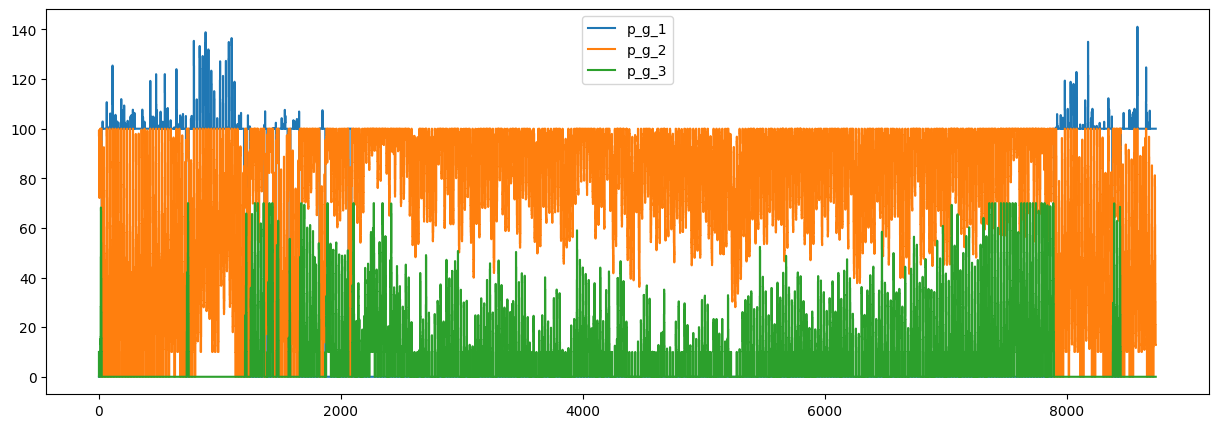

In [135]:
df_res[["p_g_1", "p_g_2", "p_g_3"]].plot(drawstyle="steps", figsize = (15,5))

<Axes: >

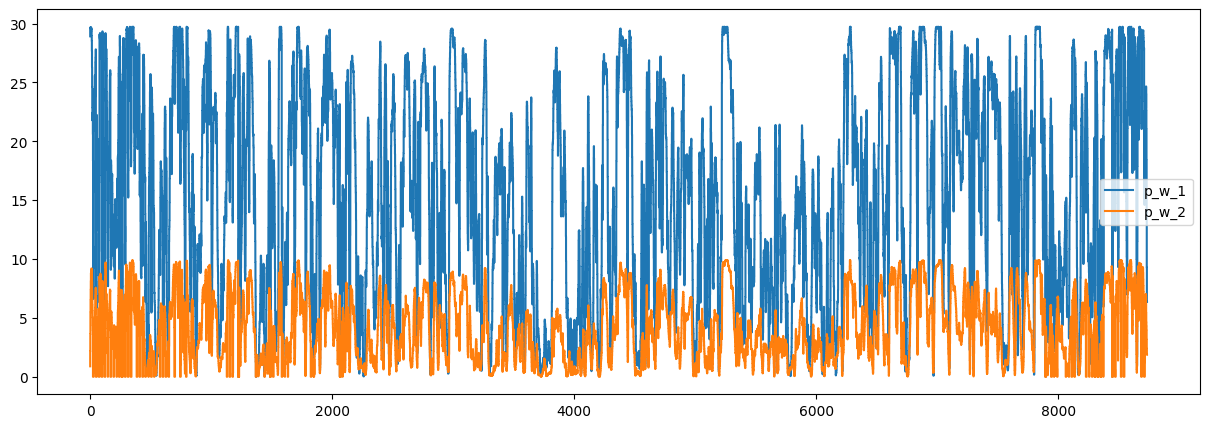

In [136]:
df_res.plot(y = ["p_w_1", "p_w_2"], drawstyle="steps", figsize = (15,5))

## Task 2: Data preperation

In [137]:
from sklearn.preprocessing import StandardScaler
x = np.vstack((Wind[:days*24,], Demand[:days*24,])).T

# Add one lag to the input data
# x = np.hstack((x, np.roll(x, 1, axis=0)))
x =  np.roll(x, 1, axis=0)
y = df_res[[f"u{g+1}" for g in range(G)]].values
x = x[:len(y)]

# Scale input data
scaler = StandardScaler()
x = scaler.fit_transform(x)


# Split into training, validation and test sets
train_test_fraction = 0.8
train_val_fraction = 0.8
n = len(x)
train_test_split = int(n * train_test_fraction)
train_val_split = int(train_test_split * train_val_fraction)

x_train = x[:train_test_split]
x_train_train = x_train[:train_val_split]
x_val = x_train[train_val_split:]
x_test = x[train_test_split:]

y_train = y[:train_test_split]
y_train_train = y_train[:train_val_split]
y_val = y_train[train_val_split:]
y_test = y[train_test_split:]


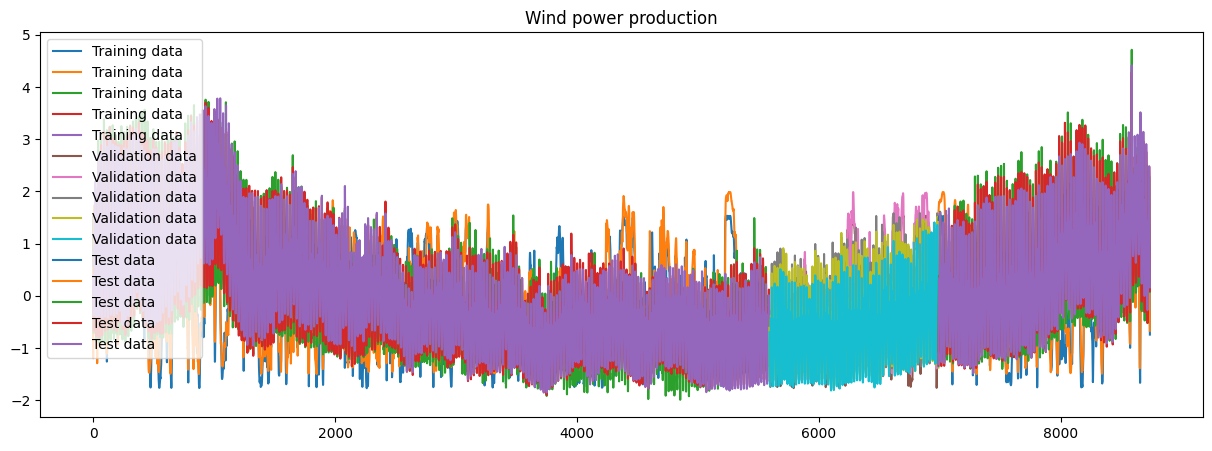

In [138]:
# Plot training, validatino and test data in sequence
plt.figure(figsize=(15,5))
plt.plot(x_train_train, label="Training data")
plt.plot(np.arange(len(x_train_train), len(x_train_train) + len(x_val), 1), x_val, label="Validation data")
plt.plot(np.arange(len(x_train), len(x_train) + len(x_test), 1), x_test, label="Test data")
plt.legend()
plt.title("Wind power production")
plt.show()


## Task 3: Train classifiers

Train both linear and non-linear methods. Could be
- Linear
    - Logistic Regression
    - Linear Support Vector Machine (SVM)
- Non-linear
    - Decision Tree
    - k-Nearest Neighbors
    - Neural Networks
    - Ensemble  methods
        - Random Forest
        - Gradient Boosting


In [139]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

def predict_classes(classifiers, names):
        evaluations = {}
        for classifier, name in zip(classifiers, names):
            # Train classifier
            y_pred = np.zeros(y_test.shape)
            for g in range(G):
                clf = classifier()
                clf.fit(x_train, y_train[:,g])
                y_pred[:,g] = clf.predict(x_test)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            conf_matrix = confusion_matrix(y_test.flatten(), y_pred.flatten())
            evaluations[name] = {"predictions": y_pred, "accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall, "confusion_matrix": conf_matrix}
        return evaluations



## Task 4: Evaluate models

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

classifiers = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, SVC, KNeighborsClassifier]
names = ["Logistic Regression", "Decision Tree", "Random Forest", "SVC", "KNN"]
evaluations = predict_classes(classifiers, names)
df = pd.DataFrame(evaluations)
df

,Logistic Regression,Decision Tree,Random Forest,SVC,KNN
predictions,"[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ..."
accuracy,0.41476,0.533753,0.6373,0.650458,0.643021
f1,0.738659,0.792343,0.81192,0.808032,0.804895
precision,0.794324,0.813436,0.829278,0.817814,0.81301
recall,0.723689,0.789843,0.80989,0.812897,0.804878
confusion_matrix,"[[1684, 567], [827, 2166]]","[[1690, 561], [629, 2364]]","[[1754, 497], [569, 2424]]","[[1718, 533], [560, 2433]]","[[1715, 536], [584, 2409]]"


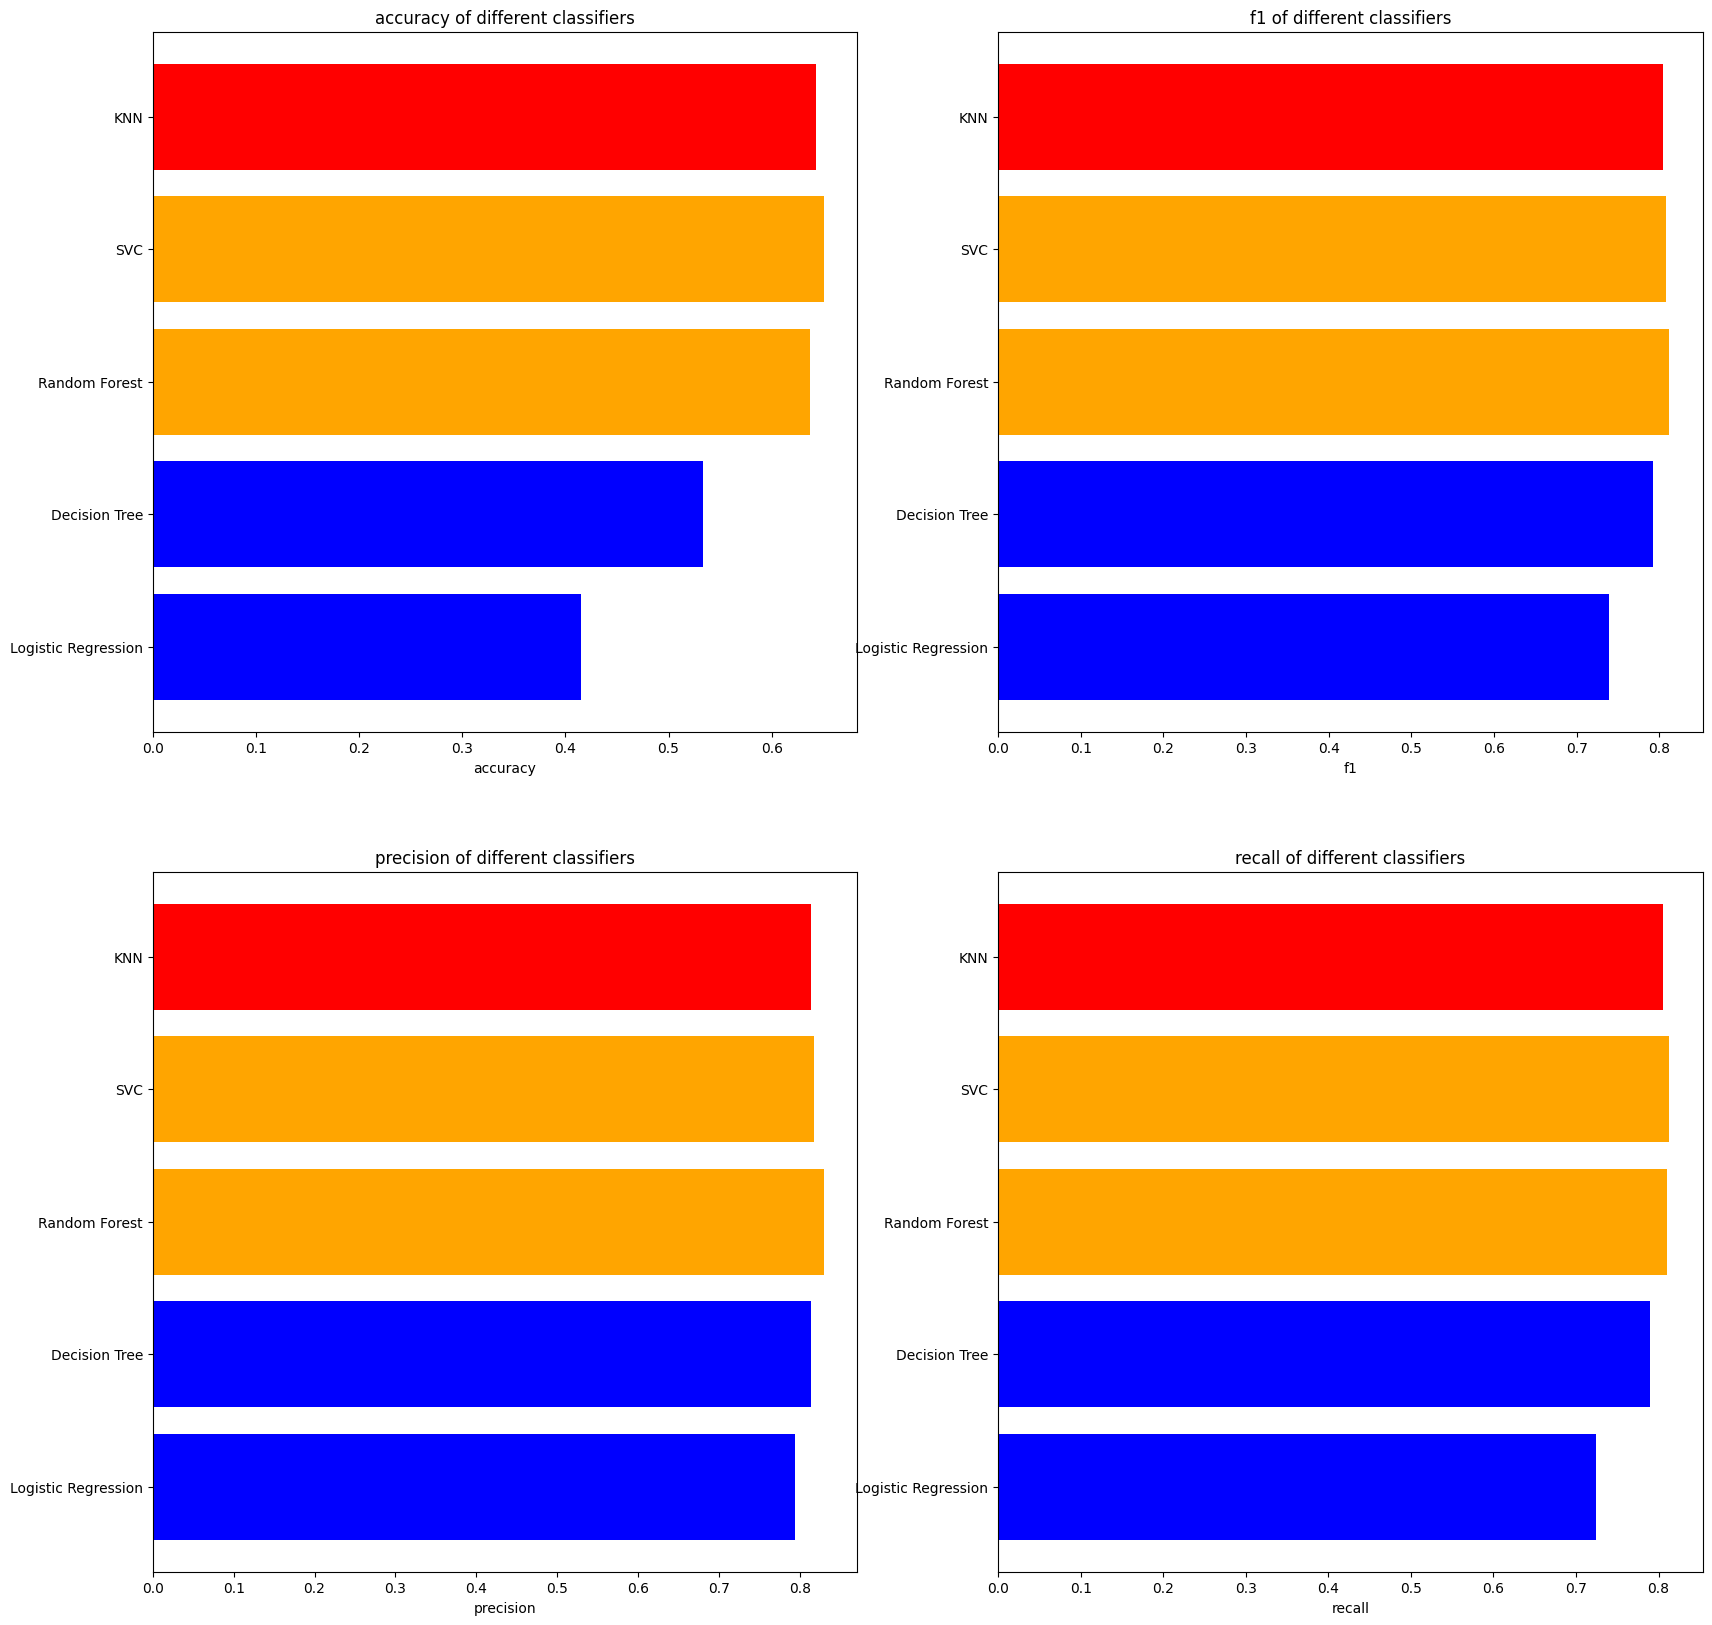

In [141]:
colors = ["blue", "blue", "orange", "orange", "red"]

fig, axs = plt.subplots(2, 2, figsize=(20,20))

metrics = ["accuracy", "f1", "precision", "recall"]

for i, metric in enumerate(metrics):
    axs[i//2, i%2].barh(names, [evaluations[name][metric] for name in names], color=colors)
    axs[i//2, i%2].set_xlabel(metric)
    axs[i//2, i%2].set_title(f"{metric} of different classifiers")
plt.show()


One thing is how often the models correctly predicts the binary variables, another is how big an impact the wrong prediction have. What would happen if we fixed the binaries to the predicted values and ran the optimizer again?

In [142]:
x_test = scaler.inverse_transform(x_test)
wind, demand = x_test[:,0:2].T, x_test[:,2:4].T

days = int(np.ceil(len(y_test)/24))


for n in names:
    infeasible_days = 0
    for day in range(days):
        infeasible_days += unit_commitment(x_test[day*24:(day+1)*24, 0:2].T, x_test[day*24:(day+1)*24, 0:2].T, evaluations[n]["predictions"][day*24:(day+1)*24, :].T)

    print(n + f" Model is infeasible for %.2f %% of tested days" % (infeasible_days/days*100))

Logistic Regression Model is infeasible for 80.82 % of tested days
Decision Tree Model is infeasible for 90.41 % of tested days
Random Forest Model is infeasible for 91.78 % of tested days
SVC Model is infeasible for 100.00 % of tested days
KNN Model is infeasible for 98.63 % of tested days


We see that even though some of the models achieve around 70% accuracy, most days would be infeasible if we were to use the predictions as input to our model.